### 1. Import

In [1]:
# Base Imports
import pandas as pd
import matplotlib.pyplot as plt

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# NLTK Imports
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import util
from nltk import pos_tag

# Others
import re
import pickle

# Readability
import textstat
# Boxplot
import seaborn as sns

In [57]:
# Read the files
df1 = pd.read_csv('archive_kaggle_data/Constraint_Train.csv')
df2 = pd.read_csv('archive_kaggle_data/Constraint_Val.csv')

# Combine the dataframes
total_df = pd.concat([df1, df2], ignore_index=True)

# Store fake news
fake_df = total_df[total_df["label"] == "fake"]
# Store real news
real_df = total_df[total_df["label"] == "real"]

# Replace label with +1 /-1
fake_df['label'] = fake_df['label'].replace('fake', 1)
fake_df['source'] = 'competition'
real_df['label'] = real_df['label'].replace('real', -1)
real_df['source'] = 'competition'


/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/3946603073.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['label'] = fake_df['label'].replace('fake', 1)
/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/3946603073.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['source'] = 'competition'
/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/3946603073.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [58]:
# Read in fake news tweets from Truth Seeker dataset
fake_df2 = pd.read_csv('covid_df_false.csv')
print(len(fake_df2))

# Labels
fake_df2['label'] = 1

# For now, just keep tweet and label 
fake_df2 = fake_df2[['tweet', 'favourites', 'retweets', 'label', 'followers_count']]

# Rename column to sync it with official communciation df 
fake_df2 = fake_df2.rename(columns={'followers_count': 'followers'})

# add source
fake_df2['source'] = 'truth_seeker'


8854


In [59]:
# Read in official tweets
official_df = pd.read_csv('tweets_official.csv')

# Create labels
official_df['label'] = -1

# Drop "is covid" column
official_df.drop("is_covid", axis=1, inplace=True)

official_df['source'] = 'official'

In [60]:
# Combine the two data frames

combined_df = pd.concat([official_df, fake_df, fake_df2], ignore_index=True)
print(len(combined_df))

28880


In [5]:
# Combine Real and Fake News dataframe
combined_df_real_and_fake = pd.concat([fake_df, real_df], ignore_index=True)
print(len(combined_df_real_and_fake))

8560


In [53]:
# Load our Emoji and Emoticon Dictionary for the preprocessing

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

### Observe Data

In [54]:
combined_df

,id,tweet,favourites,retweets,followers,label
0,1.265661e+18,Media briefing on #COVID19 with @DrTedros http...,1009.0,361.0,12269129.0,-1
1,1.359097e+18,RT @MattHancock: Our social care workforce hav...,0.0,22.0,691760.0,-1
2,1.308421e+18,These are the symptoms you should be looking o...,43.0,64.0,691760.0,-1
3,1.344742e+18,An ongoing CDC study of household spread of #C...,105.0,61.0,5554474.0,-1
4,1.322471e+18,70% of workers on minimum wages find it hard t...,381.0,149.0,1822573.0,-1
...,...,...,...,...,...,...
28875,NaN,@JennaEllisEsq @johncardillo What happened to ...,0.0,0.0,33.0,1
28876,NaN,@TheInsiderPaper Get it from Pelosi &amp; the ...,3.0,1.0,7795.0,1
28877,NaN,- Twisted President Trump's words to make it s...,2215.0,326.0,875635.0,1
28878,NaN,@zeretti If you are licensed to carry a concea...,0.0,0.0,16.0,1


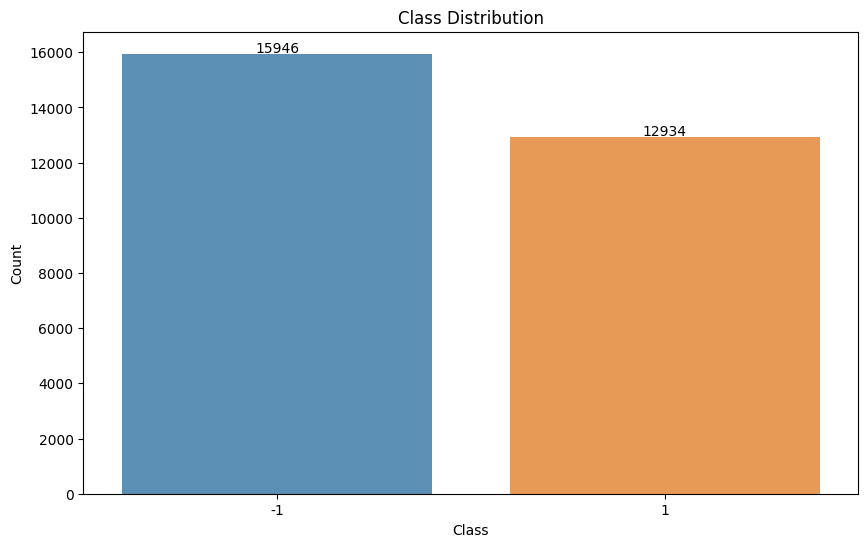

In [55]:
# Count instances of each class
class_counts = combined_df['label'].value_counts()

# Plot
plt.figure(figsize=(10, 6))

# Create a bar plot with seaborn
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Add counts on top of the bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center')

plt.show()


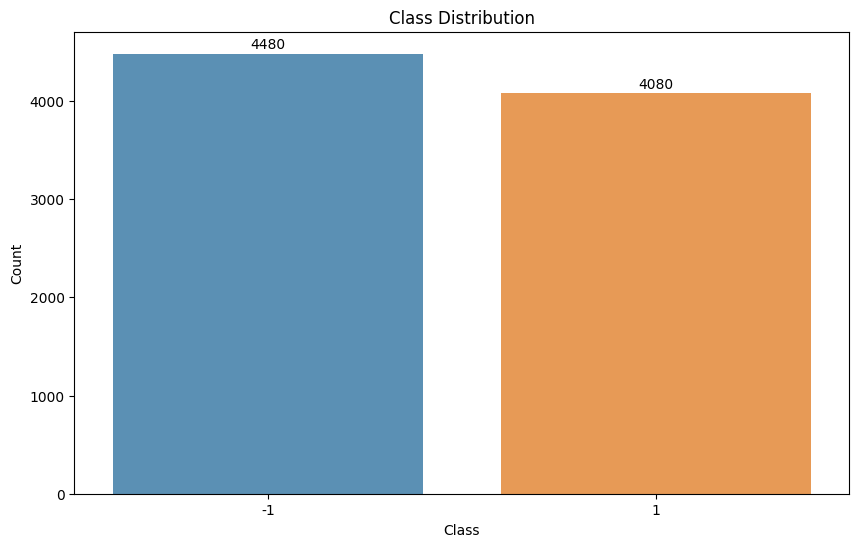

In [9]:
# Count instances of each class
class_counts = combined_df_real_and_fake['label'].value_counts()

# Plot
plt.figure(figsize=(10, 6))

# Create a bar plot with seaborn
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Add counts on top of the bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center')

plt.show()


In [80]:
# Get a sample to display
sample = combined_df.sample(n=25)

for i, article in enumerate(sample):
    print(f'Article {i+1}:')
    print("Label: ", sample["label"].iloc[i])
    print("Source: ", sample["source"].iloc[i], "\n")
    print(sample["tweet"].iloc[i], "\n")

Article 1:
Label:  1
Source:  truth_seeker 

@AttiMagyar @LeeAlon8 @KathMLee1 Yes, let's move on already.  I did in March 2020 after myself, my family, friends, coworkers got Covid and we all beat it without any Vaccine.  Amazing?  pretty common actually.  How?  A strong immune system then natural immunity since. 

Article 2:
Label:  -1
Source:  official 

“Nurses are at high risk of being infected, as we spend most of our time with patients. People already have an increased understanding of, and gratitude for our work,” says #nurse Nadiya. #SupportNursesAndMidwives #COVID19 

Find out more ➡️ https://t.co/eXdUESI9mC 

Article 3:
Label:  1
Source:  competition 

The COVID-19 pandemic was caused by the 5G network. All influenza pandemics are caused by the "electrification" of the earth. 

Article 4:
Label:  1
Source:  truth_seeker 

@gtconway3d What a sick bastard trump is To even hint that our healthcare workers are profiting off of COVID-19. Its beyond reprehensible. Our doctors get m

In [81]:
# # Assume that `articles` is a pandas Series with the text of each article
# for i, article in enumerate(combined_df_real_and_fake["tweet"]):
#     print(f'Article {i+1}:')
#     print("Label: ", combined_df["label"].iloc[i])
#     print("Source: ", combined_df["source"].iloc[i], "\n")
#     print(combined_df["tweet"].iloc[i], "\n")
#     if i > 40:
#         break


In [82]:
# Compare the length
official_df['length'] = official_df['tweet'].apply(len)
fake_df['length'] = fake_df['tweet'].apply(len)
real_df['length'] = real_df['tweet'].apply(len)

combined_df['length'] = combined_df['tweet'].apply(len)
combined_df_real_and_fake['length'] = combined_df_real_and_fake['tweet'].apply(len)

/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/3348529742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['length'] = fake_df['tweet'].apply(len)
/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/3348529742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_df['length'] = real_df['tweet'].apply(len)


In [83]:
print(fake_df.sort_values(by='length', ascending=False))


        id                                              tweet  label  \
270    271  Amoxi" Capsule made in US is the only medicine...      1   
1109  1110  Actors" applauded Macron when he visited the s...      1   
6306  6307  Man visited Albany N.Y. days before dying from...      1   
773    774  @giles7452 @William05548637 @CheeseNBranston @...      1   
4349  4350  @Narvuntien @jimdtweet @MedBennett @TheDisproo...      1   
...    ...                                                ...    ...   
2407  2408                            Cocaine cures COVID-19.      1   
3141  3142                             COVID-19 TEST a FRAUD?      1   
1883  1884                              COVID-19 is Airborne.      1   
268    269                               There is no pandemic      1   
1140  1141                                 Pier Luigi Bersani      1   

           source  length  
270   competition    8846  
1109  competition    5040  
6306  competition    2086  
773   competition     9

In [84]:
print(official_df.sort_values(by='length', ascending=False))


                        id                                              tweet  \
14397  1252345545563058185  @WelshGasDoc @MattHancock @Jeremy_Hunt @JonAsh...   
11012  1273304877981224960  @Sister_Medicine @BorisJohnson @MattHancock @N...   
12738  1273305013763407874  @doctor_oxford @NHSEmployers @MattHancock @NHS...   
4731   1334882362170224641  @micalrg @MZ_GOV_PL @a_niedzielski @GIS_gov @g...   
1660   1265993660816150528  @bbc5live @BenPBradshaw @Emmabarnett @BBCSound...   
...                    ...                                                ...   
12301  1313421994856046592  #EBSpecial on #COVID19 Day 2 https://t.co/LHF4...   
500    1263773586357010432  Live from #EB147. #COVID19 https://t.co/RuQaUp...   
10155  1282593105930223616  #Keepcool during #COVID19. https://t.co/J3nH6g...   
14999  1313119014915207168     #EBSpecial on #COVID19 https://t.co/z9W0NbaBSD   
1172   1313066914306957312     #EBSpecial on #COVID19 https://t.co/5x6BxAUfLW   

       favourites  retweets

In [85]:
print(real_df.sort_values(by='length', ascending=False))

        id                                              tweet  label  \
8153  1734  I'm so happy that we’re able to do something v...     -1   
7394   975  @anjan1588 @COVIDNewsByMIB @MoHFW_INDIA @PMOIn...     -1   
3852  3853  @anjan1588 @COVIDNewsByMIB @MoHFW_INDIA @PMOIn...     -1   
2159  2160  @tmccormick @alexismadrigal @pplscouncil @kiss...     -1   
1988  1989  Yes. As of today Case #FatalityRate stands at ...     -1   
...    ...                                                ...    ...   
3057  3058  Standby we've got a little bug to squash on th...     -1   
511    512  Second wave of PPE shortage is here. https://t...     -1   
361    362  #Coronavirus surges in Arizona. https://t.co/z...     -1   
4885  4886  @dandiemann @joshtpm At least we're not still ...     -1   
3600  3601                 Now cases. https://t.co/APHMFyirSj     -1   

           source  length  
8153  competition    2135  
7394  competition     445  
3852  competition     436  
2159  competition     3

In [86]:
# Find outliers. There are three entries that consist of many tweets that were not split. We remove them.
# Other outliers that still exceed the character limit that is expected are caused by replies, which display all the user
# handles the reply refers to. After preprocessing, this issue should be mitigated.

# Remove the three outliers, all with length > 2,000
combined_df = combined_df[combined_df['length'] <= 2000]
combined_df_real_and_fake = combined_df_real_and_fake[combined_df_real_and_fake['length'] <= 2000]


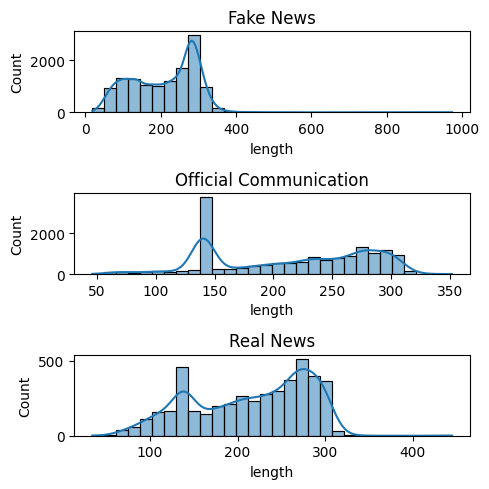

In [87]:
# Create a figure and axes
fig, ax = plt.subplots(3, 1, figsize=(5, 5))

# Plot the histogram for the class '1'
sns.histplot(data=combined_df[combined_df['label'] == 1],
             x='length',
             bins=30,
             ax=ax[0],
             kde=True)
ax[0].set_title('Fake News')

# Plot the histogram for the class '-1'
sns.histplot(data=combined_df[combined_df['label'] == -1],
             x='length',
             bins=30,
             ax=ax[1],
             kde=True)
ax[1].set_title('Official Communication')

# Plot the histogram for the class '-1'
sns.histplot(data=combined_df_real_and_fake[combined_df_real_and_fake['label'] == -1],
             x='length',
             bins=30,
             ax=ax[2],
             kde=True)
ax[2].set_title('Real News')

# Show the plot
plt.tight_layout()
plt.show()


In [114]:
combined_df

,id,tweet,favourites,retweets,followers,label,source,length
0,1.265661e+18,Media briefing on #COVID19 with @DrTedros http...,1009.0,361.0,12269129.0,-1,official,65
1,1.359097e+18,RT @MattHancock: Our social care workforce hav...,0.0,22.0,691760.0,-1,official,140
2,1.308421e+18,These are the symptoms you should be looking o...,43.0,64.0,691760.0,-1,official,203
3,1.344742e+18,An ongoing CDC study of household spread of #C...,105.0,61.0,5554474.0,-1,official,260
4,1.322471e+18,70% of workers on minimum wages find it hard t...,381.0,149.0,1822573.0,-1,official,242
...,...,...,...,...,...,...,...,...
28875,NaN,@JennaEllisEsq @johncardillo What happened to ...,0.0,0.0,33.0,1,truth_seeker,305
28876,NaN,@TheInsiderPaper Get it from Pelosi &amp; the ...,3.0,1.0,7795.0,1,truth_seeker,139
28877,NaN,- Twisted President Trump's words to make it s...,2215.0,326.0,875635.0,1,truth_seeker,267
28878,NaN,@zeretti If you are licensed to carry a concea...,0.0,0.0,16.0,1,truth_seeker,135


In [158]:
import numpy as np 

# Only look at the the sources with likes and shares
filtered_df = combined_df[combined_df['source'].isin(['official', 'truth_seeker'])]

# Group by the label and calculate descriptive statistics for each group
print(filtered_df.groupby('label')[['favourites', 'retweets', 'followers']].describe())


      favourites                                                          \
           count        mean         std  min  25%   50%    75%      max   
label                                                                      
-1       15946.0  166.868682  805.200619  0.0  0.0  45.0  132.0  42509.0   
 1        8854.0   24.931218  702.461637  0.0  0.0   0.0    2.0  55301.0   

      retweets              ...                 followers                \
         count        mean  ...    75%      max     count          mean   
label                       ...                                           
-1     15946.0  136.650884  ...  109.0  26236.0   15946.0  5.325256e+06   
 1      8854.0    5.993788  ...    0.0  11380.0    8854.0  4.823231e+03   

                                                                             
                std       min       25%        50%          75%         max  
label                                                                        
-1     5.

<Figure size 1000x700 with 0 Axes>

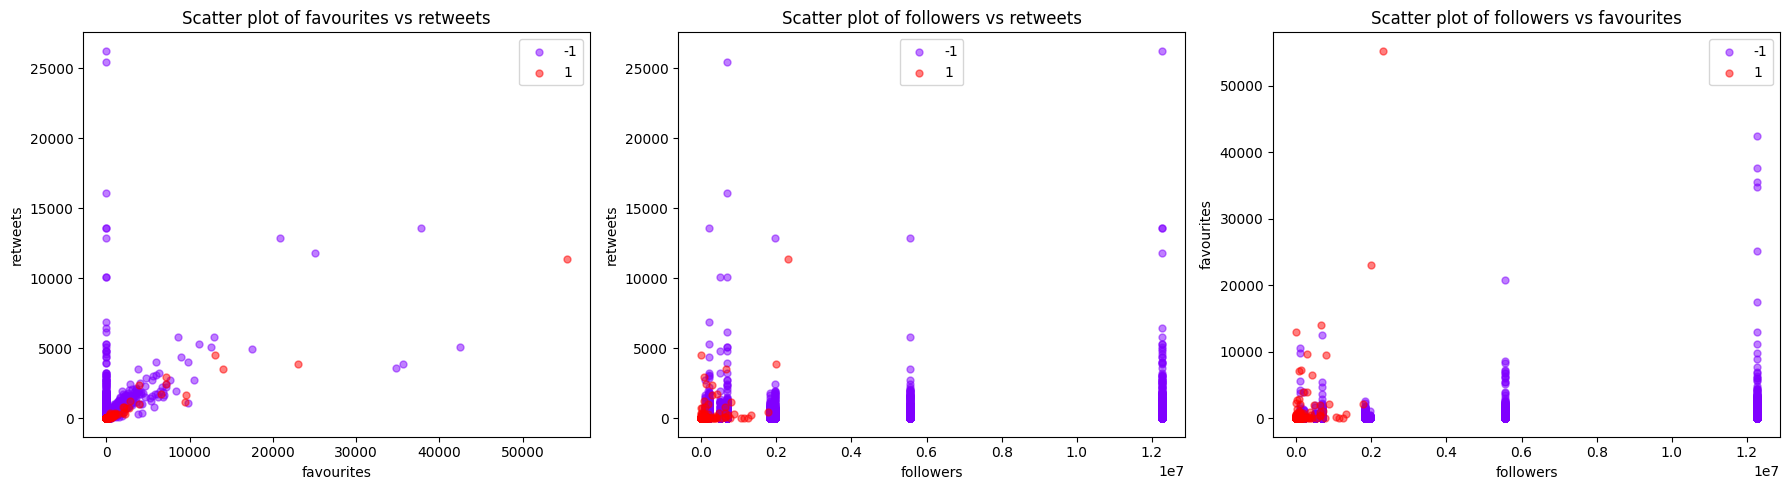

In [127]:
# Plot scatter plots
plt.figure(figsize=(10, 7))

# List of labels to color code
labels = filtered_df['label'].unique()

# Generate a color map for visualization
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

combinations = [('favourites', 'retweets'), ('followers', 'retweets'), ('followers', 'favourites' )]

plt.figure(figsize=(18, 5))

for i, (x, y) in enumerate(combinations):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, subplot index
    for label, color in zip(labels, colors):
        subset = filtered_df[filtered_df['label'] == label]
        plt.scatter(subset[x], subset[y], s=25, c=[color], label=str(label), alpha=0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Scatter plot of {x} vs {y}')
    plt.legend()

plt.tight_layout()
plt.show()


In [156]:
# Somehow, our classifier failed to scrape favourite counts for all reply tweets. 
combined_df[~((combined_df['source'] == 'official') & 
                          (combined_df['favourites'] == 0) & 
                          (combined_df['retweets'] > 0))]


,id,tweet,favourites,retweets,followers,label,source,length
0,1.265661e+18,Media briefing on #COVID19 with @DrTedros http...,1009.0,361.0,12269129.0,-1,official,65
2,1.308421e+18,These are the symptoms you should be looking o...,43.0,64.0,691760.0,-1,official,203
3,1.344742e+18,An ongoing CDC study of household spread of #C...,105.0,61.0,5554474.0,-1,official,260
4,1.322471e+18,70% of workers on minimum wages find it hard t...,381.0,149.0,1822573.0,-1,official,242
5,1.358819e+18,"""This is clearly concerning news. However, the...",26.0,13.0,12269129.0,-1,official,121
...,...,...,...,...,...,...,...,...
28875,NaN,@JennaEllisEsq @johncardillo What happened to ...,0.0,0.0,33.0,1,truth_seeker,305
28876,NaN,@TheInsiderPaper Get it from Pelosi &amp; the ...,3.0,1.0,7795.0,1,truth_seeker,139
28877,NaN,- Twisted President Trump's words to make it s...,2215.0,326.0,875635.0,1,truth_seeker,267
28878,NaN,@zeretti If you are licensed to carry a concea...,0.0,0.0,16.0,1,truth_seeker,135


left-skewed outliers 0
right-skewed outliers 2848


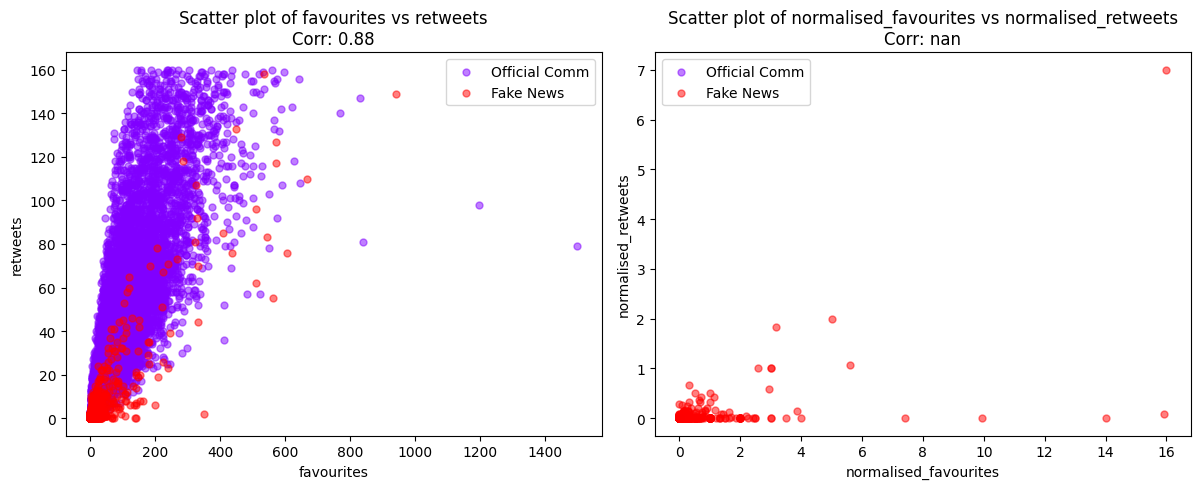

In [167]:
q1 = filtered_df['retweets'].quantile(0.25)
q3 = filtered_df['retweets'].quantile(0.75)
iqr = q3 - q1

print("left-skewed outliers",sum(filtered_df['retweets'] < (q1 - 1.5 * iqr)))
print("right-skewed outliers",sum(filtered_df['retweets'] > (q3 + 1.5 * iqr)))

# only keep rows in dataframe that are NOT outliers
filtered_df_no_outliers = filtered_df[~((filtered_df['retweets'] < (q1 - 1.5 * iqr)) | (filtered_df['retweets'] > (q3 + 1.5 * iqr)))]

# as tweet replies have no favourite counts, let's also exclude them for the sake of visualisation
filtered_df_no_outliers = filtered_df_no_outliers[~((filtered_df_no_outliers['source'] == 'official') & 
                                        (filtered_df_no_outliers['favourites'] == 0) & 
                                        (filtered_df_no_outliers['retweets'] > 0))]

# Further, let's normalise 
filtered_df_no_outliers['normalised_favourites'] = filtered_df_no_outliers['favourites'] / filtered_df_no_outliers['followers']
filtered_df_no_outliers['normalised_retweets'] = filtered_df_no_outliers['retweets'] / filtered_df_no_outliers['followers']


combinations = [('favourites', 'retweets'), ('normalised_favourites', 'normalised_retweets')]

# scatter plots
plt.figure(figsize=(18, 5))

# Define a dictionary to map the labels
label_dict = {1: 'Fake News', -1: 'Official Comm'}

for i, (x, y) in enumerate(combinations):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, subplot index
    for label, color in zip(labels, colors):
        subset = filtered_df_no_outliers[filtered_df_no_outliers['label'] == label]
        plt.scatter(subset[x], subset[y], s=25, c=[color], label=label_dict[label], alpha=0.5)
        # calculate the correlation coefficient
        corr_coef = subset[x].corr(subset[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Scatter plot of {x} vs {y}\nCorr: {corr_coef:.2f}')
    plt.legend()

plt.tight_layout()
plt.show()


In [163]:
filtered_df_no_outliers

,id,tweet,favourites,retweets,followers,label,source,length,normalised_favourites,normalised_retweets
2,1.308421e+18,These are the symptoms you should be looking o...,43.0,64.0,691760.0,-1,official,203,0.000062,0.000093
3,1.344742e+18,An ongoing CDC study of household spread of #C...,105.0,61.0,5554474.0,-1,official,260,0.000019,0.000011
4,1.322471e+18,70% of workers on minimum wages find it hard t...,381.0,149.0,1822573.0,-1,official,242,0.000209,0.000082
5,1.358819e+18,"""This is clearly concerning news. However, the...",26.0,13.0,12269129.0,-1,official,121,0.000002,0.000001
6,1.265938e+18,"Close contact and early, exclusive #breastfeed...",212.0,96.0,12269129.0,-1,official,253,0.000017,0.000008
...,...,...,...,...,...,...,...,...,...,...
28874,NaN,@essenviews thats the million dollar question ...,0.0,0.0,244.0,1,truth_seeker,295,0.000000,0.000000
28875,NaN,@JennaEllisEsq @johncardillo What happened to ...,0.0,0.0,33.0,1,truth_seeker,305,0.000000,0.000000
28876,NaN,@TheInsiderPaper Get it from Pelosi &amp; the ...,3.0,1.0,7795.0,1,truth_seeker,139,0.000385,0.000128
28878,NaN,@zeretti If you are licensed to carry a concea...,0.0,0.0,16.0,1,truth_seeker,135,0.000000,0.000000


### Pre-Processing Step 1

In [88]:
# Convert Emojis and Emoticons
def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(
            r'(' + emot + ')',
            "_".join(Emoji_Dict[emot].replace(",",
                                              "").replace(":",
                                                          "").split()), text)
    return text


def convert_emoticons_to_word(text):
    for emot in Emoticon_Dict:
        text = re.sub(u'(' + emot + ')',
                      "_".join(Emoticon_Dict[emot].replace(",",
                                                           "").split()), text)
    return text


In [89]:
def preprocess_tweet_step_one(tweet):
    # Remove @user_handles
    tweet = re.sub(r'\B@[\w]*', '', tweet)
    # Remove URL
    tweet = re.sub(r"https?:\/\/t.co\/[\w]*", '', tweet)
    # Remove hastags in front of words
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Replace '&amp'
    tweet = re.sub(r'&amp;', '&', tweet)
    # Replace Emoji with word
    tweet = convert_emoticons_to_word(tweet)
    # Replace Emoticon with word
    tweet = convert_emoticons_to_word(tweet)
    return tweet

In [100]:
combined_df

,id,tweet,favourites,retweets,followers,label,source,length
0,1.265661e+18,Media briefing on #COVID19 with @DrTedros http...,1009.0,361.0,12269129.0,-1,official,65
1,1.359097e+18,RT @MattHancock: Our social care workforce hav...,0.0,22.0,691760.0,-1,official,140
2,1.308421e+18,These are the symptoms you should be looking o...,43.0,64.0,691760.0,-1,official,203
3,1.344742e+18,An ongoing CDC study of household spread of #C...,105.0,61.0,5554474.0,-1,official,260
4,1.322471e+18,70% of workers on minimum wages find it hard t...,381.0,149.0,1822573.0,-1,official,242
...,...,...,...,...,...,...,...,...
28875,NaN,@JennaEllisEsq @johncardillo What happened to ...,0.0,0.0,33.0,1,truth_seeker,305
28876,NaN,@TheInsiderPaper Get it from Pelosi &amp; the ...,3.0,1.0,7795.0,1,truth_seeker,139
28877,NaN,- Twisted President Trump's words to make it s...,2215.0,326.0,875635.0,1,truth_seeker,267
28878,NaN,@zeretti If you are licensed to carry a concea...,0.0,0.0,16.0,1,truth_seeker,135


In [103]:
# Create feature DF
feature_df = combined_df[['favourites', 'retweets', 'followers',	'source', 'label']]
print(feature_df)

# Create feature DF real and fake
# feature_df_real_and_fake = combined_df_real_and_fake[['favourites', 'retweets', 'followers',	'source', 'label']]
# print(feature_df_real_and_fake)

       favourites  retweets   followers        source  label
0          1009.0     361.0  12269129.0      official     -1
1             0.0      22.0    691760.0      official     -1
2            43.0      64.0    691760.0      official     -1
3           105.0      61.0   5554474.0      official     -1
4           381.0     149.0   1822573.0      official     -1
...           ...       ...         ...           ...    ...
28875         0.0       0.0        33.0  truth_seeker      1
28876         3.0       1.0      7795.0  truth_seeker      1
28877      2215.0     326.0    875635.0  truth_seeker      1
28878         0.0       0.0        16.0  truth_seeker      1
28879         1.0       0.0      5454.0  truth_seeker      1

[28877 rows x 5 columns]


In [104]:
# Call preprocessing function
feature_df['preprocessed'] = combined_df['tweet'].apply(
    preprocess_tweet_step_one)

# Call preprocessing function
# feature_df_real_and_fake['preprocessed'] = combined_df_real_and_fake['tweet'].apply(
#     preprocess_tweet_step_one)

/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/1945095162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['preprocessed'] = combined_df['tweet'].apply(


### Outlier Handling

In [106]:
# Compare the length
feature_df['length_preprocessed'] = feature_df['preprocessed'].apply(len)
# feature_df_real_and_fake['length_preprocessed'] = feature_df_real_and_fake['preprocessed'].apply(len)


/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_52365/1332225707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['length_preprocessed'] = feature_df['preprocessed'].apply(len)


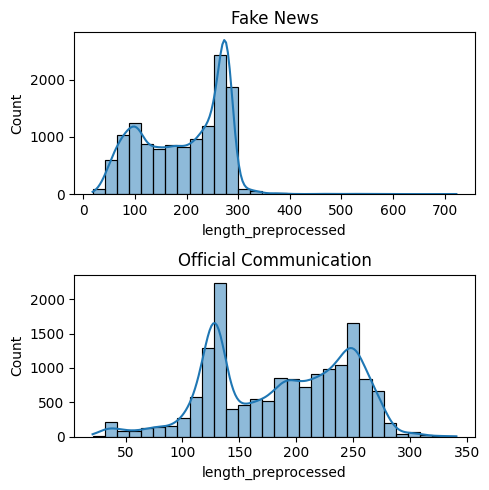

In [108]:
# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot the histogram for the class '1'
sns.histplot(data=feature_df[feature_df['label'] == 1],
             x='length_preprocessed',
             bins=30,
             ax=ax[0],
             kde=True)
ax[0].set_title('Fake News')

# Plot the histogram for the class '-1'
sns.histplot(data=feature_df[feature_df['label'] == -1],
             x='length_preprocessed',
             bins=30,
             ax=ax[1],
             kde=True)
ax[1].set_title('Official Communication')

# # Plot the histogram for the class '-1'
# sns.histplot(data=feature_df_real_and_fake[feature_df_real_and_fake['label'] == -1],
#              x='length_preprocessed',
#              bins=30,
#              ax=ax[2],
#              kde=True)
# ax[2].set_title('Real News')

# Show the plot
plt.tight_layout()
plt.show()


In [109]:
print(feature_df.sort_values(by='length_preprocessed', ascending=False))


       favourites  retweets   followers       source  label  \
19024         NaN       NaN         NaN  competition      1   
17918         NaN       NaN         NaN  competition      1   
19219         NaN       NaN         NaN  competition      1   
17397         NaN       NaN         NaN  competition      1   
16691         NaN       NaN         NaN  competition      1   
...           ...       ...         ...          ...    ...   
1172        221.0      57.0  12269182.0     official     -1   
16829         NaN       NaN         NaN  competition      1   
14999       211.0      71.0  12269320.0     official     -1   
16052         NaN       NaN         NaN  competition      1   
16471         NaN       NaN         NaN  competition      1   

                                            preprocessed  length_preprocessed  
19024  In our laboratory, we found trace amount of th...                  723  
17918  COVID-19, Take one minute and read. Be underst...                  703  
192

In [110]:
# Even after preprocessing, we note that there are some more outliers in our
# fake news dataset. This is because supposingly not all posts stem from Twitter
# (e.g. some are from FB, Instagram, etc.). This per se is not a problem, but there
# shouldn't be a systematic difference to the ones we obtain from the scraped
# official communication oens. Thus, we choose to exclude any posts with a length higher
# than 300. 

print(
    len(feature_df[(feature_df['length_preprocessed'] >= 300)
                    & (feature_df['label'] == -1)]))

print(
    len(feature_df[(feature_df['length_preprocessed'] >= 350)
                    & (feature_df['label'] == 1)]))


88
38


In [111]:
# Exclude all posts of length > 300

feature_df = feature_df[feature_df['length_preprocessed'] <= 300]
# feature_df_real_and_fake = feature_df_real_and_fake[feature_df_real_and_fake['length_preprocessed'] <= 300]

print(len(feature_df))
# print(len(feature_df_real_and_fake))

28609


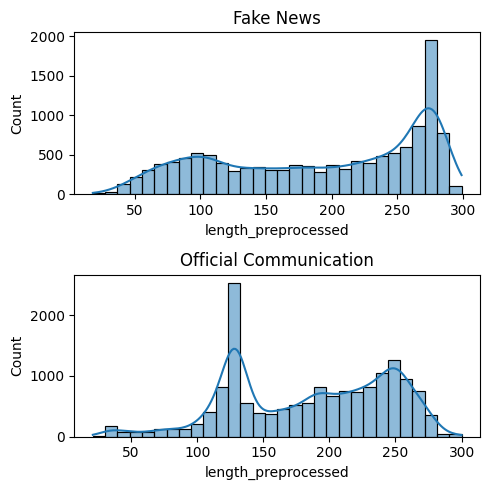

In [112]:
# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot the histogram for the class '1'
sns.histplot(data=feature_df[feature_df['label'] == 1],
             x='length_preprocessed',
             bins=30,
             ax=ax[0],
             kde=True)
ax[0].set_title('Fake News')

# Plot the histogram for the class '-1'
sns.histplot(data=feature_df[feature_df['label'] == -1],
             x='length_preprocessed',
             bins=30,
             ax=ax[1],
             kde=True)
ax[1].set_title('Official Communication')

# sns.histplot(data=feature_df_real_and_fake[feature_df_real_and_fake['label'] == -1],
#              x='length_preprocessed',
#              bins=30,
#              ax=ax[2],
#              kde=True)
# ax[2].set_title('Real News')

# Show the plot
plt.tight_layout()
plt.show()


### Feature Extraction

In [113]:
# Save to csv for upload to GDrive
feature_df.to_csv('combined_df.csv', index=False)
# feature_df_real_and_fake.to_csv('combined_df_real_and_fake.csv', index=False)


#### LLM Interest Annotation

In [ ]:
# import encoding here 

#### LLM Sentiment

In [534]:
# Read back in from CSV, processed in Google Colab due to Memory Constraints
combined_df_BERT = pd.read_csv("combined_df_BERT.csv")

# Apply same outlier corrections as above (used the original file to obtain LLM ratings)
combined_df_BERT = combined_df_BERT[combined_df_BERT['length'] <= 2000]
print(len(combined_df_BERT))

20023


In [535]:
# Read in the CSV
combined_df_RoBERTa = pd.read_csv("combined_df_RoBERTa.csv")

# Apply same outlier corrections as above (used the original file to obtain LLM ratings)
combined_df_RoBERTa = combined_df_RoBERTa[combined_df_RoBERTa['length'] <= 2000]
print(len(combined_df_RoBERTa))

20023


In [536]:
# Because for I mixed them for some reason, let's sort them again
combined_df_BERT = combined_df_BERT.sort_values(by='id', ascending=True)
combined_df_RoBERTa = combined_df_RoBERTa.sort_values(by='id', ascending=True)


In [488]:
# Assign feature df
feature_df["sentiment_BERT"] = combined_df_BERT["sentiment_BERT"]
feature_df["sentiment_RoBERTa"] = combined_df_RoBERTa["sentiment_RoBERTa"]

In [489]:
feature_df

,label,id,sentiment_vader,sentiment_BERT,sentiment_RoBERTa
0,1,3,0.0772,4.0,1.0
1,1,8,-0.8074,1.0,1.0
2,1,9,0.5586,4.0,1.0
3,1,10,0.0000,1.0,0.0
4,1,12,-0.1531,4.0,1.0
...,...,...,...,...,...
20021,-1,1280765354747342849,0.9451,4.0,1.0
20022,-1,1252344219470987265,0.8567,5.0,1.0
20023,-1,1293520105503100928,0.4939,5.0,1.0
20024,-1,1322223878219960323,-0.3818,5.0,1.0


In [ ]:
feature_df["sentiment_RoBERTa"]

#### VADER

In [ ]:
# VADER Sentiment (used on unprocessed text, as punctuation and cases are considered)

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score using VADER
def calculate_sentiment_vader(text):
    return (sid.polarity_scores(text)["compound"])

# Apply the function to each row in the DataFrame
feature_df['sentiment_vader'] = combined_df['tweet'].apply(
    calculate_sentiment_vader)


# Apply the function to each row in the DataFrame Real and Fake
feature_df_real_and_fake['sentiment_vader'] = combined_df_real_and_fake['tweet'].apply(
    calculate_sentiment_vader)

# Display the DataFrame with the new 'sentiment_vader' column
print(feature_df)
print(feature_df_real_and_fake)


#### Readability

In [491]:
# Kincaid Readabilility score
# Note that for calculating the Flesch-Kincaid readability score, steps like tokenization,
# lemmatization/stemming, and stop word removal are not necessary because the formula for the
# score relies on the original sentence structure, word count, and syllable count.
# The basic cleaning like lowercasing, and removing HTML tags, noise, punctuation, and special characters would suffice.

# Apply the Flesch-Kincaid grade level test to each row in the DataFrame
feature_df['readability'] = combined_df['tweet'].apply(
    textstat.flesch_kincaid_grade)

feature_df_real_and_fake['readability'] = combined_df_real_and_fake['tweet'].apply(
    textstat.flesch_kincaid_grade)

# Display the DataFrame with the new 'readability' column
print(feature_df)
print(feature_df_real_and_fake)


       label                   id  sentiment_vader  sentiment_BERT  \
0          1                    3           0.0772             4.0   
1          1                    8          -0.8074             1.0   
2          1                    9           0.5586             4.0   
3          1                   10           0.0000             1.0   
4          1                   12          -0.1531             4.0   
...      ...                  ...              ...             ...   
20021     -1  1280765354747342849           0.9451             4.0   
20022     -1  1252344219470987265           0.8567             5.0   
20023     -1  1293520105503100928           0.4939             5.0   
20024     -1  1322223878219960323          -0.3818             5.0   
20025     -1  1339599142956384256           0.9217             5.0   

       sentiment_RoBERTa  readability  
0                    1.0         14.7  
1                    1.0         13.9  
2                    1.0          7.2  

#### Count Exclamation, Question Mark, Digits and Hashtags

In [492]:
# Exclamation
# Propbably more than one exclamation mark is rare, not very serious at all (not even in fake news)

def count_exclamation_marks(text):
    return text.count('!')

# Apply the function to each row in the DataFrame
feature_df['exclamation_marks'] = combined_df['tweet'].apply(
    count_exclamation_marks)

# Display the DataFrame with the new 'exclamation_marks' column
print(feature_df)


       label                   id  sentiment_vader  sentiment_BERT  \
0          1                    3           0.0772             4.0   
1          1                    8          -0.8074             1.0   
2          1                    9           0.5586             4.0   
3          1                   10           0.0000             1.0   
4          1                   12          -0.1531             4.0   
...      ...                  ...              ...             ...   
20021     -1  1280765354747342849           0.9451             4.0   
20022     -1  1252344219470987265           0.8567             5.0   
20023     -1  1293520105503100928           0.4939             5.0   
20024     -1  1322223878219960323          -0.3818             5.0   
20025     -1  1339599142956384256           0.9217             5.0   

       sentiment_RoBERTa  readability  exclamation_marks  
0                    1.0         14.7                  0  
1                    1.0         13.9    

In [ ]:
# Count questions
# Punctuation
# Propbably more than one exclamation mark is rare, not very serious at all (not even in fake news)

def count_question_marks(text):
    return text.count('?')

# Apply the function to each row in the DataFrame
feature_df['question_marks'] = combined_df['tweet'].apply(
    count_question_marks)

# Display the DataFrame with the new 'exclamation_marks' column
print(feature_df)


In [ ]:
# Count digits

def count_exclamation_marks(text):
    return text.count('\d')

# Apply the function to each row in the DataFrame
feature_df['digits'] = combined_df['tweet'].apply(
    count_exclamation_marks)

# Display the DataFrame with the new 'exclamation_marks' column
print(feature_df)



In [ ]:
# Count Hashtags

def count_exclamation_marks(text):
    return text.count('#')

# Apply the function to each row in the DataFrame
feature_df['hashtags'] = combined_df['tweet'].apply(
    count_exclamation_marks)

# Display the DataFrame with the new 'exclamation_marks' column
print(feature_df)


### Preprocessing Step 2

In [494]:
def preprocess_tweet_step_two(tweet):
    # Remove numbers
    tweet = re.sub(r"\b\d+((\.|\,)\d+)?\b", '', tweet)
    # Remove punctuation
    tweet = ''.join([ch for ch in tweet if ch.isalnum() or ch.isspace()])
    # Lowercase
    tweet = tweet.lower()
    # Tokenize tweet
    tweet = nltk.word_tokenize(tweet)
    # return final tweet
    return tweet

In [495]:
# Call preprocessing function
feature_df['preprocessed'] = combined_df['tweet'].apply(
    preprocess_tweet)

feature_df_real_and_fake['preprocessed'] = combined_df_real_and_fake['tweet'].apply(
    preprocess_tweet)

In [497]:
# Lexical Diversity (before removing stopwords)

def lexical_diversity(words):
    # Compute the number of unique words (types)
    types = set(words)
    # Compute the total number of words (tokens)
    tokens = len(words)
    # Compute the type-token ratio (TTR)
    ttr = len(types) / tokens if tokens > 0 else 0
    return ttr

# Apply the function to each text in your DataFrame
feature_df['lexical_diversity'] = feature_df['preprocessed'].apply(lexical_diversity)
feature_df_real_and_fake['lexical_diversity'] = feature_df_real_and_fake['preprocessed'].apply(lexical_diversity)


In [304]:
# Remove stop words
# stop_words = set(stopwords.words('english'))

# combined_df['preprocessed'] = combined_df['preprocessed'].apply(
#   lambda x: [word for word in x if word not in stop_words])


In [498]:
# Count Superlatives by PoS Tagging

def count_superlatives(words):

    # Tag parts of speech
    tagged_words = pos_tag(words)

    # Count superlatives
    superlatives = sum(1 for word, pos in tagged_words
                       if pos in {'JJS', 'RBS'})

    return superlatives


# Apply the function to each text in your DataFrame
feature_df['superlatives'] = feature_df['preprocessed'].apply(
    count_superlatives)
feature_df_real_and_fake['superlatives'] = feature_df_real_and_fake['preprocessed'].apply(
    count_superlatives)


In [499]:
# Stemming
# stemmer = nltk.PorterStemmer()

# feature_df['preprocessed'] = feature_df['preprocessed'].apply(
#     lambda x: ' '.join([stemmer.stem(word) for word in x]))

# feature_df_real_and_fake['preprocessed'] = feature_df_real_and_fake['preprocessed'].apply(
#     lambda x: ' '.join([stemmer.stem(word) for word in x]))


In [500]:
# # Handling Negations (we do it in the end, because it would impact removing stopwords,
# # lexical diversity and counting superlatives otherwise)


# # Handling negations
# def handling_negations(words):
#     words = nltk.sentiment.util.mark_negation(words)
#     return " ".join(text)


# # combined_df['preprocessed'] = combined_df['preprocessed'].apply(
# #  handling_negations)


### Feature Comparison

In [507]:
# Drop features 
features = feature_df.columns.drop('label').drop('id').drop('length_preprocessed').drop('preprocessed')
print(features)

Index(['sentiment_vader', 'sentiment_BERT', 'sentiment_RoBERTa', 'readability',
       'exclamation_marks', 'lexical_diversity', 'superlatives'],
      dtype='object')


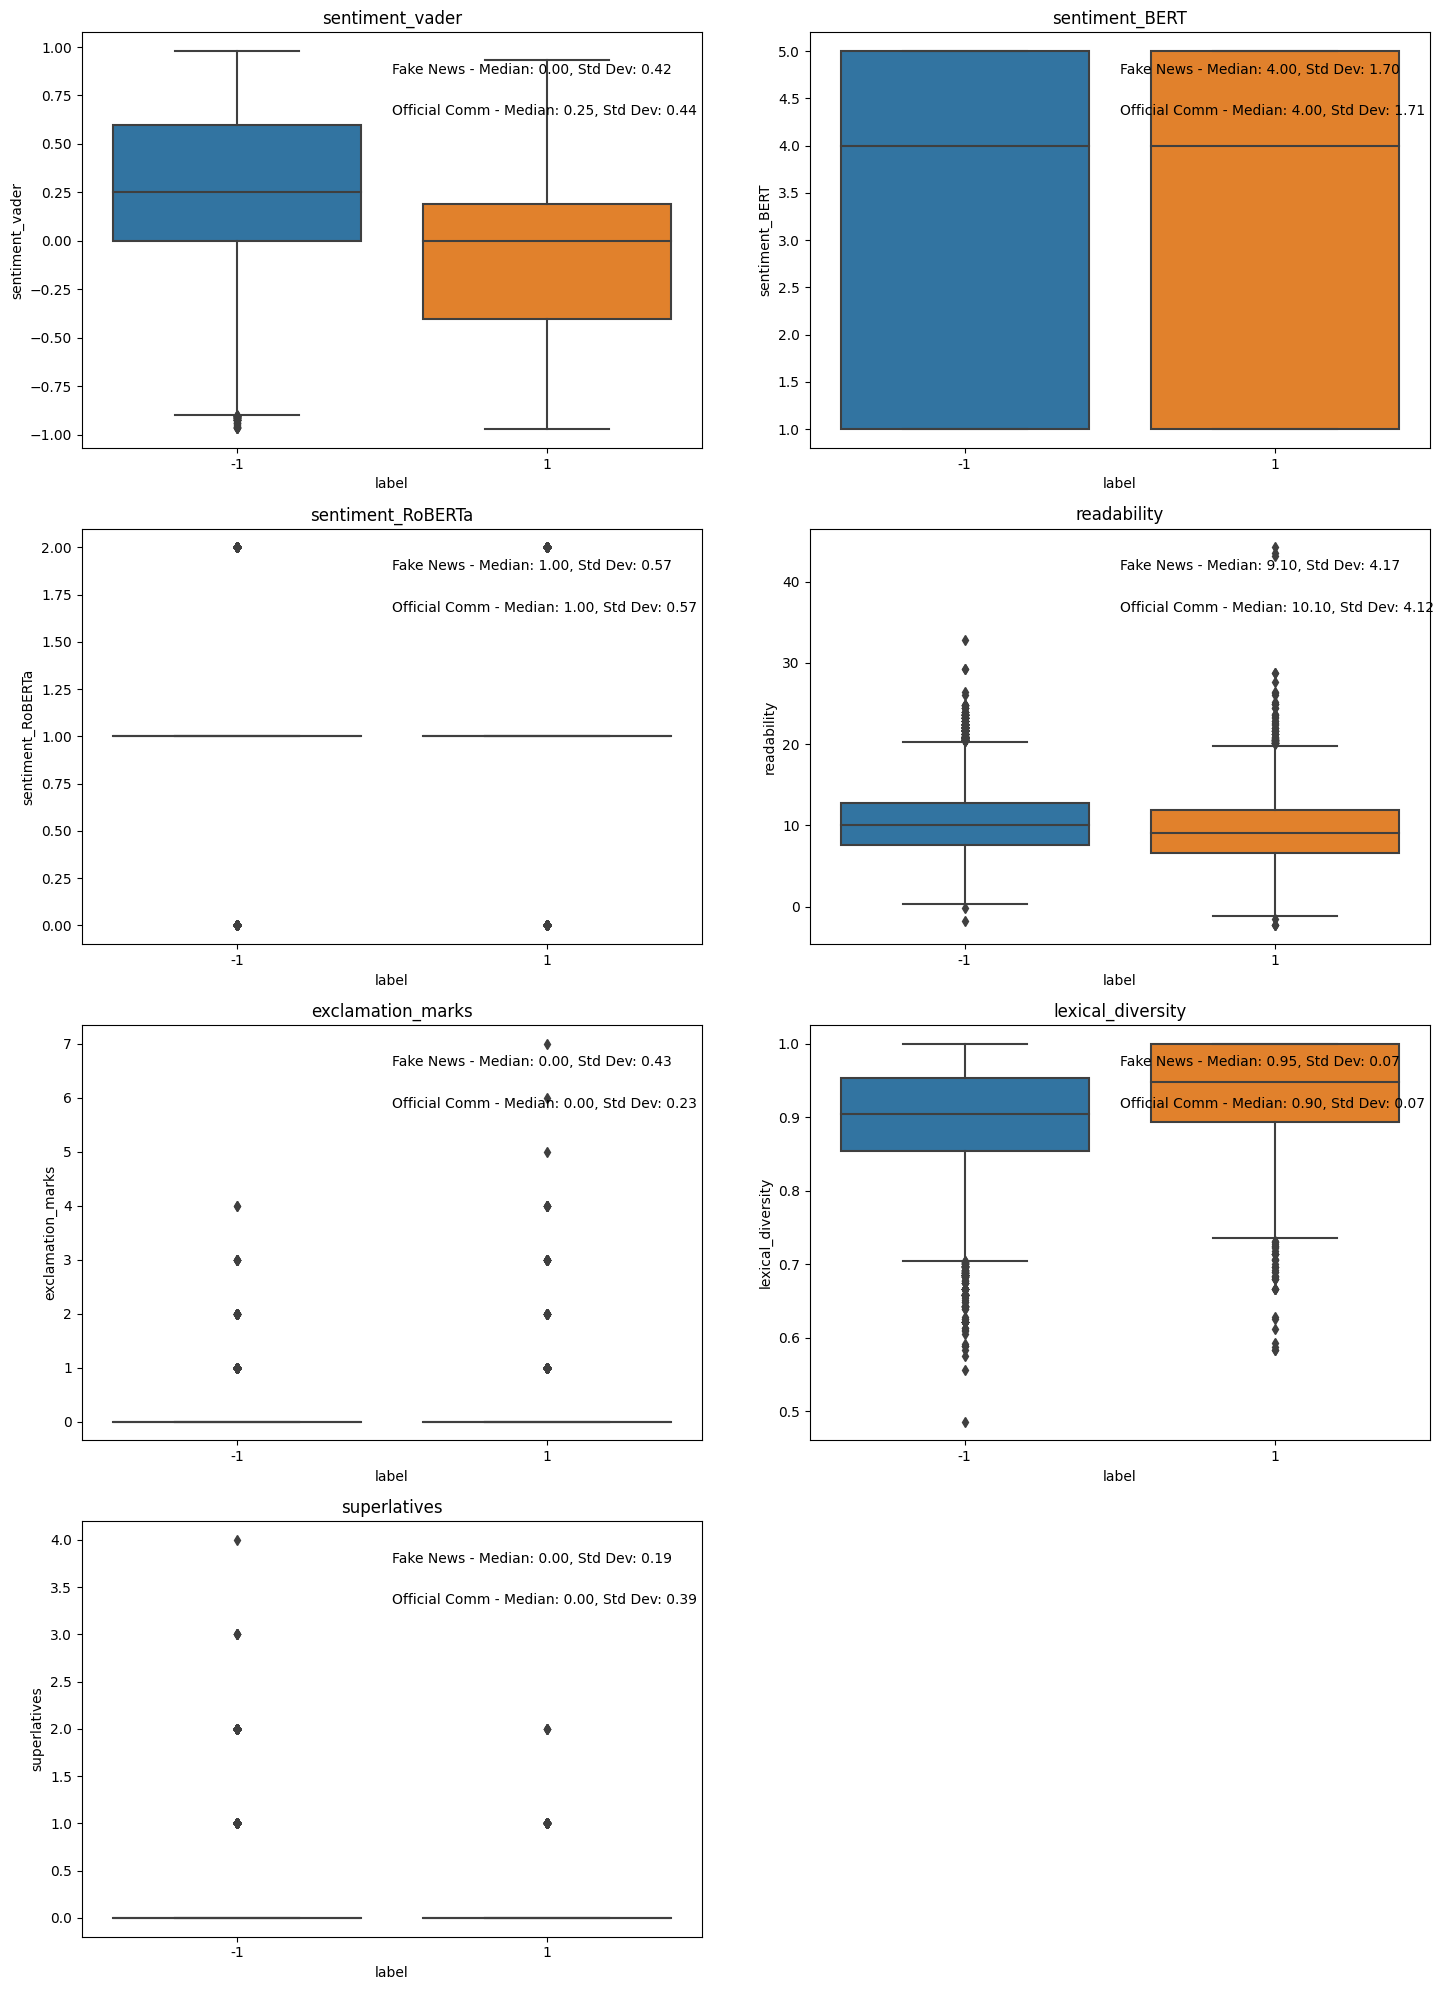

In [508]:
# Define the number of rows and columns for the subplot grid
n = len(features)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()  # Flatten to make indexing easier

for i, feature in enumerate(features):
    # Calculate median and standard deviation for the feature by class
    median_fake = feature_df[feature_df['label'] == 1][feature].median()
    std_dev_fake = feature_df[feature_df['label'] == 1][feature].std()

    median_real = feature_df[feature_df['label'] == -1][feature].median()
    std_dev_real = feature_df[feature_df['label'] == -1][feature].std()

    # Create the boxplot
    sns.boxplot(x='label', y=feature, data=feature_df, ax=axs[i])

    # Set the title with median and standard deviation
    axs[i].set_title(f'{feature}')

    # Add the calculated stats in the plot
    axs[i].text(0.5, 0.9, f'Fake News - Median: {median_fake:.2f}, Std Dev: {std_dev_fake:.2f}',
                transform=axs[i].transAxes)
    axs[i].text(0.5, 0.8, f'Official Comm - Median: {median_real:.2f}, Std Dev: {std_dev_real:.2f}',
                transform=axs[i].transAxes)

# Remove extra subplots
if len(features) < len(axs):
    for i in range(len(features), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [ ]:
# Drop features 
features_real_and_fake = feature_df_real_and_fake.columns.drop('label').drop('id').drop('length_preprocessed').drop('preprocessed')
print(features_real_and_fake)

In [ ]:
# Define the number of rows and columns for the subplot grid
n = len(features_real_and_fake)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()  # Flatten to make indexing easier

for i, feature in enumerate(features_real_and_fake):
    # Calculate median and standard deviation for the feature by class
    median_fake = feature_df_real_and_fake[feature_df_real_and_fake['label'] == 1][feature].median()
    std_dev_fake = feature_df_real_and_fake[feature_df_real_and_fake['label'] == 1][feature].std()

    median_real = feature_df_real_and_fake[feature_df_real_and_fake['label'] == -1][feature].median()
    std_dev_real = feature_df_real_and_fake[feature_df_real_and_fake['label'] == -1][feature].std()

    # Create the boxplot
    sns.boxplot(x='label', y=feature, data=feature_df_real_and_fake, ax=axs[i])

    # Set the title with median and standard deviation
    axs[i].set_title(f'{feature}')

    # Add the calculated stats in the plot
    axs[i].text(0.5, 0.9, f'Fake News - Median: {median_fake:.2f}, Std Dev: {std_dev_fake:.2f}',
                transform=axs[i].transAxes)
    axs[i].text(0.5, 0.8, f'Real News - Median: {median_real:.2f}, Std Dev: {std_dev_real:.2f}',
                transform=axs[i].transAxes)

# Remove extra subplots
if len(features_real_and_fake) < len(axs):
    for i in range(len(features), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


#### Readability 

Takes into consideration:
Total words: The total number of words in the text.
Total sentences: The total number of sentences in the text.
Total syllables: The total number of syllables in the text.

Note that as fake news are on average slightly shorter, this influences the readability score. 

#### Sentiment

VADER (Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. VADER uses a combination of a sentiment lexicon, a set of heuristic rules, and incorporates grammatical and syntactical features such as capitalization and punctuation to improve its sentiment analysis performance.

VADER's SentimentIntensityAnalyzer() function yields four scores:

Positive (pos): The probability of the sentiment being positive.
Negative (neg): The probability of the sentiment being negative.
Neutral (neu): The probability of the sentiment being neutral.
Compound: The aggregated sentiment score, which is calculated using the previous three measurements. This score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive). The more positive this score, the more positive the sentiment of the text, and vice versa.
The function sid.polarity_scores(text)["compound"] that you used in your code returns this compound score.

The length of a text can potentially influence the sentiment scores because more words can convey more sentiments, whether positive, negative, or neutral, or a mix of all. But it's also important to note that sentiment analysis can be affected by factors such as context, sarcasm, negations, and intensifiers that are not strictly related to the length of the text.

The potential influence of text length on sentiment scores might be more nuanced compared to readability scores. For example, a longer tweet doesn't necessarily mean it has stronger sentiment; it could contain mixed sentiments that could neutralize each other in the compound score. In contrast, a shorter tweet might express a strong sentiment more concisely, leading to a high positive or negative compound score.



## Export 

In [602]:
feature_df.to_csv('feature_df.csv')